# Module 2 Project Part 2

## Clustering

In [1]:
import pandas as pd

# Read in data 
climate_daily = pd.read_csv("fires_climate_daily.csv")
treecover_yearly = pd.read_csv("fires_treecover_yearly.csv")
fires_yearly = pd.read_csv("fires_yearly.csv")



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_distances

# Data Prep
X = climate_daily[['fire_count', 'mean_frp']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled)


[[-0.0934432  -0.05830915]
 [-0.20422676  0.33160017]
 [-0.0934432   0.5162103 ]
 ...
 [-0.2965464  -0.44535383]
 [-0.30577836 -0.44376237]
 [-0.30577836 -0.46413314]]


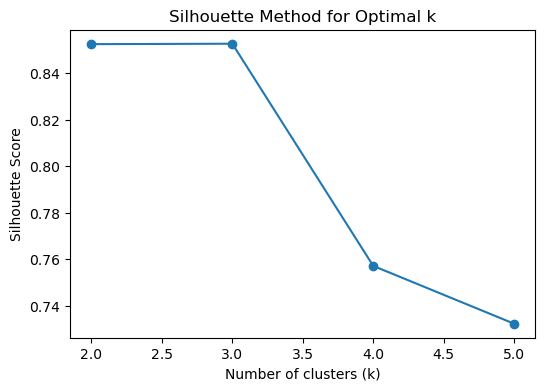

In [3]:
# KMeans Clustering
silhouette_scores = {}
for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[k] = score

# Plot silhouette scores
plt.figure(figsize=(6,4))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()

In [4]:
# KMeans k = 2
kmeans = KMeans(n_clusters=2, random_state=42)
climate_daily['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
print(climate_daily['kmeans_cluster'].value_counts())

# KMeans k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
climate_daily['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
print(climate_daily['kmeans_cluster'].value_counts())

# Fit final KMeans with best k (highest silhouette score, k = 3)
kmeans = KMeans(n_clusters=3, random_state=42)
climate_daily['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
print(climate_daily['kmeans_cluster'].value_counts())

kmeans_cluster
0    2374
1      91
Name: count, dtype: int64
kmeans_cluster
0    2195
1     246
2      22
3       2
Name: count, dtype: int64
kmeans_cluster
0    2387
1      51
2      27
Name: count, dtype: int64


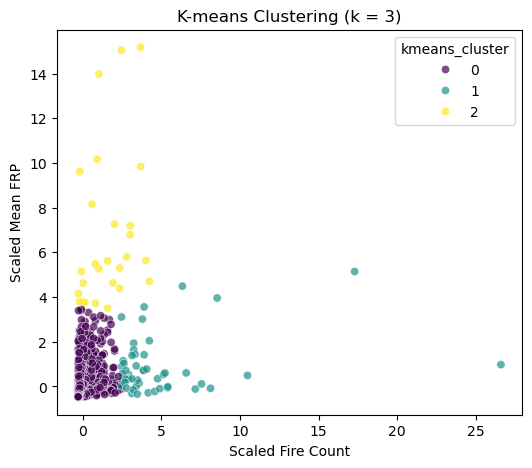

In [5]:
# Scatterplot of k-means clusters
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=climate_daily['kmeans_cluster'], palette='viridis', alpha=0.7)
plt.xlabel("Scaled Fire Count")
plt.ylabel("Scaled Mean FRP")
plt.title(f"K-means Clustering (k = 3)")
plt.show()

/var/folders/r3/tzdbl_qj34sbn29x3zvp8f640000gn/T/ipykernel_71817/2828566125.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cosine_dist, method='average')


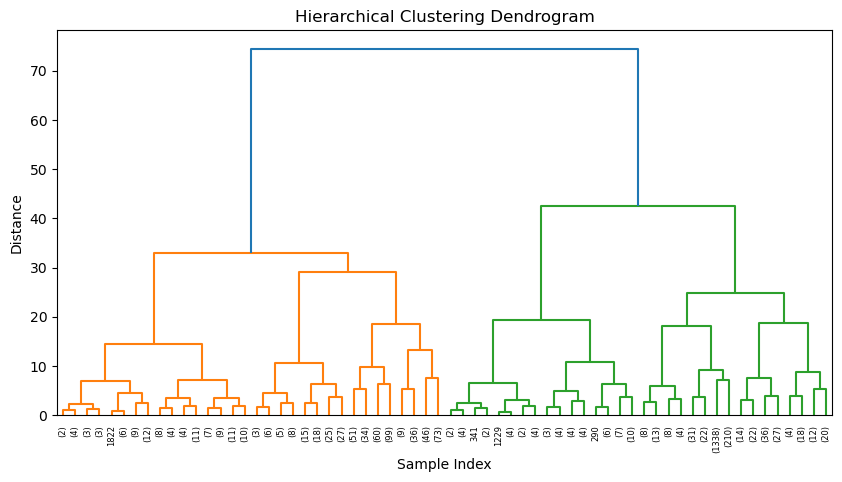

In [6]:
# Hierarchical Clustering
# Compute cosine distance matrix
cosine_dist = cosine_distances(X_scaled)

# Perform hierarchical clustering (linkage)
Z = linkage(cosine_dist, method='average') 

# Dendrogram
plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


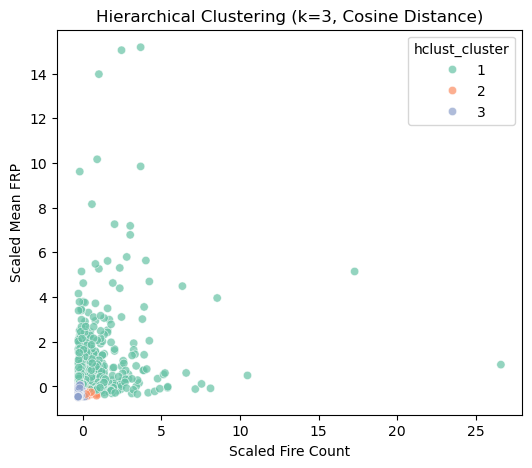

In [7]:
# Cut tree at k = best_k for comparison
hclust_labels = fcluster(Z, 3, criterion='maxclust')
climate_daily['hclust_cluster'] = hclust_labels

# Scatterplot for hierarchical clusters
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=climate_daily['hclust_cluster'], palette='Set2', alpha=0.7)
plt.xlabel("Scaled Fire Count")
plt.ylabel("Scaled Mean FRP")
plt.title(f"Hierarchical Clustering (k=3, Cosine Distance)")
plt.show()

## Principal Component Analysis (PCA)

In [8]:
df_gfw_viirs = pd.read_csv("viirs_alerts_count.csv")
df_gfw_viirs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1529 entries, 0 to 1528
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   alert__week      1529 non-null   object 
 1   alert__year      1528 non-null   float64
 2   alert__count     1528 non-null   float64
 3   confidence__cat  1528 non-null   object 
dtypes: float64(2), object(2)
memory usage: 47.9+ KB


In [12]:
treecover_loss = pd.read_csv("treecover_loss_from_fires_by_region__ha.csv")
treecover_loss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso                                 24 non-null     object 
 1   adm1                                24 non-null     int64  
 2   umd_tree_cover_loss__year           24 non-null     int64  
 3   umd_tree_cover_loss__ha             24 non-null     float64
 4   umd_tree_cover_loss_from_fires__ha  24 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.1+ KB


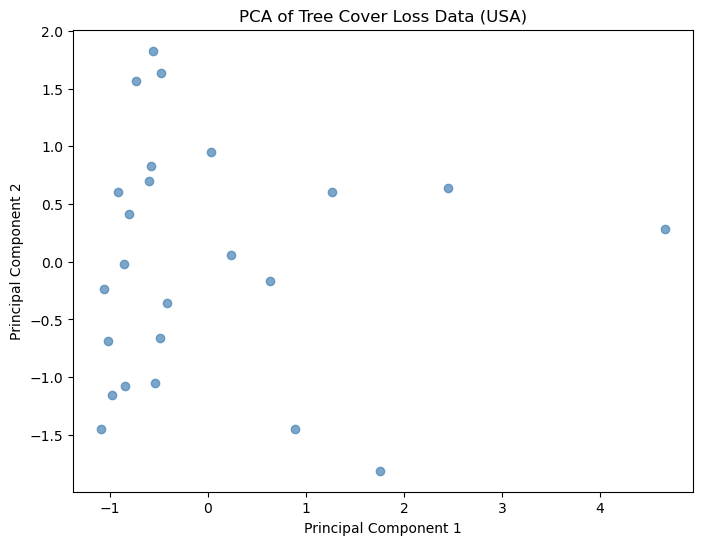

Explained variance ratio: [0.60143695 0.33568269]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Features for PCA (treecover loss data)
features = ["umd_tree_cover_loss__year", 
            "umd_tree_cover_loss__ha", 
            "umd_tree_cover_loss_from_fires__ha"]

# Select numeric data from df
X = treecover_loss[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Put results into DataFrame
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])

# Plot (no coloring by country, just one dataset)
plt.figure(figsize=(8,6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c="steelblue", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Tree Cover Loss Data (USA)")
plt.show()

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)


[[ 0.7102757   1.70257511 -0.16129975 -0.64711344  1.0804517 ]
 [ 0.63623919  1.70257511 -0.22747067 -0.64711344  1.0804517 ]
 [ 0.56220267  1.70257511  1.87345619 -0.64711344  1.0804517 ]
 [ 0.56220267  1.70257511 -0.20679226  1.54532411 -0.92553882]
 [ 0.56220267  1.70257511 -0.08272178 -0.64711344 -0.92553882]]


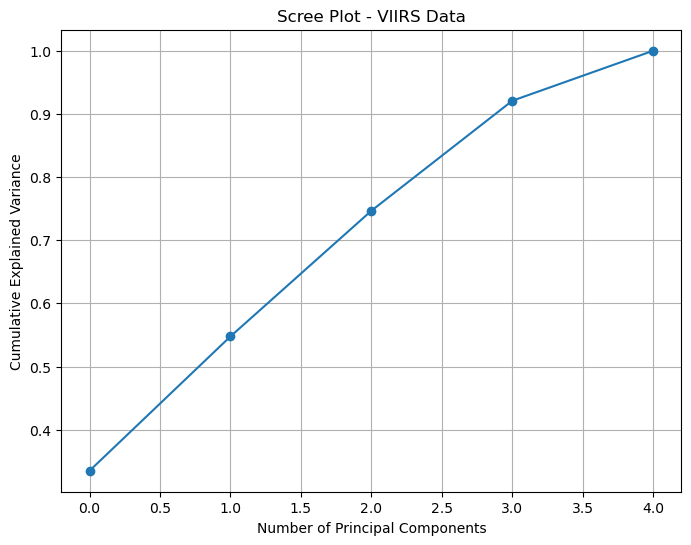

First 10 explained variance ratios: [0.33508056 0.21264445 0.19896016 0.17409885 0.07921598]
Cumulative explained variance (first 10): [0.33508056 0.54772501 0.74668518 0.92078402 1.        ]


In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Clean the data: drop rows with missing values
viirs_clean = df_gfw_viirs.dropna().copy()

# Encode the categorical variable
viirs_clean = pd.get_dummies(viirs_clean, columns=['confidence__cat'], drop_first=True)

# Standardize numeric variables
scaler = StandardScaler()
viirs_scaled = scaler.fit_transform(viirs_clean)

# Print first 5 rows of scaled data
print(viirs_scaled[:5])

# Run PCA without limiting components
pca = PCA()
viirs_pca = pca.fit_transform(viirs_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Scree plot (cumulative explained variance)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot - VIIRS Data")
plt.grid(True)
plt.show()

# Print first 10 components' variance
print("First 10 explained variance ratios:", explained_variance[:10])
print("Cumulative explained variance (first 10):", np.cumsum(explained_variance)[:10])


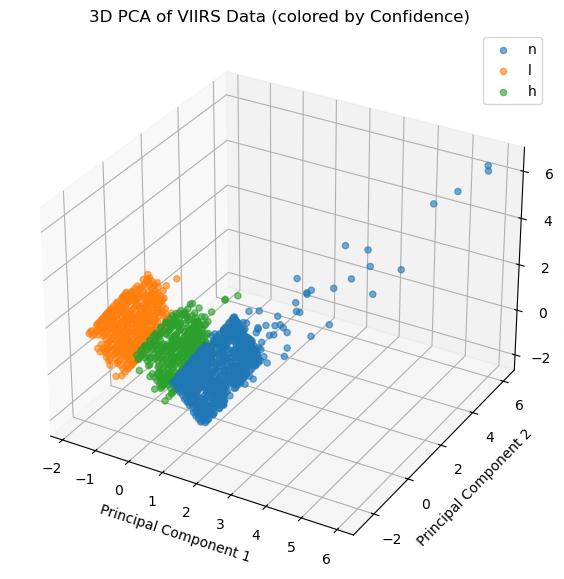

Explained variance ratio: [0.33508056 0.21264445 0.19896016]
Cumulative explained variance: [0.33508056 0.54772501 0.74668518]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

# Clean the data (keep original column for color)
viirs_clean = df_gfw_viirs.dropna().copy()
confidence_labels = viirs_clean["confidence__cat"]  # save for coloring

# One-hot encode categorical variable
viirs_encoded = pd.get_dummies(viirs_clean, columns=['confidence__cat'], drop_first=True)

# Standardize numeric variables
scaler = StandardScaler()
viirs_scaled = scaler.fit_transform(viirs_encoded)

# PCA with 3 components
pca = PCA(n_components=3)
viirs_pca = pca.fit_transform(viirs_scaled)

# Put results into DataFrame
pca_df = pd.DataFrame(data=viirs_pca, columns=["PC1", "PC2", "PC3"])
pca_df["confidence__cat"] = confidence_labels.values

# 3D scatter plot with color by confidence
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for cat in pca_df["confidence__cat"].unique():
    subset = pca_df[pca_df["confidence__cat"] == cat]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], label=cat, alpha=0.6)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA of VIIRS Data (colored by Confidence)")
ax.legend()
plt.show()

# Print explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())